<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-логистической-регрессии" data-toc-modified-id="Модель-логистической-регрессии-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель логистической регрессии</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#Модель-градиентного-бустинга-LightGBM" data-toc-modified-id="Модель-градиентного-бустинга-LightGBM-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Модель градиентного бустинга LightGBM</a></span></li><li><span><a href="#Модель-CatBoost" data-toc-modified-id="Модель-CatBoost-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Модель CatBoost</a></span></li><li><span><a href="#Проверим-лучшую-модель-в-работе" data-toc-modified-id="Проверим-лучшую-модель-в-работе-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Проверим лучшую модель в работе</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Цель проекта**

Обучить модель и классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

**Задачи проекта**

Построить модель со значением метрики качества F1 не меньше 0.75.



**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import nltk
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import re
import spacy
import tqdm
import warnings
from pymystem3 import Mystem
m = Mystem() 
import re

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm.notebook import tqdm
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()

RANDOM_STATE = 42

warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
try:
    data = pd.read_csv('toxic_comments.csv', index_col='Unnamed: 0')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col='Unnamed: 0')

Посмотрим данные.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
data.head(3)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0


In [5]:
data.describe()

,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [6]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [7]:
data.duplicated().sum() 

0

<AxesSubplot:>

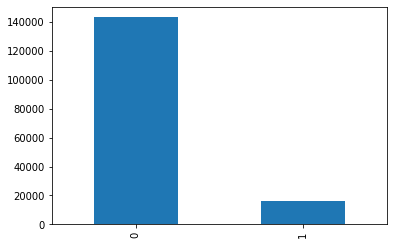

In [8]:
data['toxic'].value_counts().plot(kind='bar')

Данные содержат около 160 тысяч записей. Пропуски и дубликаты в данных отсутсвуют. Наблюдается дисбаланс классов целевого признака.

Как дополнительные материалы, рекомендую статью <a href='https://dyakonov.org/2021/05/27/imbalance/'>Дисбаланс классов</a>, очень классная, как и весь блог Дьяконова. Ещё такой <a href='https://github.com/Dyakonov/ml_hacks/blob/master/book_disbalance_public_v1.ipynb'>ноутбук</a> есть.</font>

Функция очистки и нормализации текста.

In [9]:
def text_normalizer(text):
    """
    normalizes given text according to the template
    parameters:
    - text - text to normalize
    
    returns: normalized text
    """        
    return " ".join(re.sub(r"[^a-zA-Z']", " ", text).split()).lower()

print('Compiling text_normalizer - OK')

Compiling text_normalizer - OK


In [10]:
# normalizing texts
normalized_texts = []

for row in range(data.shape[0]):
    normalized_texts.append(text_normalizer(data.iloc[row]['text']))
    
data['text'] = normalized_texts

data.head(5)

,text,toxic
0,explanation why the edits made under my userna...,0
1,d'aww he matches this background colour i'm se...,0
2,hey man i'm really not trying to edit war it's...,0
3,more i can't make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0


Напишем функцию lemmatize(text) для лемматизации комментариев.

In [11]:
WNLemmatizer = nltk.stem.WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
#ввожу функцию РОS-тэгирования слов:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,               #прилагательное
                "N": wordnet.NOUN,              #существительное
                "V": wordnet.VERB,              #глагол
                "R": wordnet.ADV                #наречие
               }  
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

#ввожу функцию леммализации тектов постов:
def lemm_text(text):
    text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    return ' '.join(text)

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [12]:
data['text'] = data['text'].apply(lemm_text) 

In [13]:
data.head(5)

,text,toxic
0,explanation why the edits make under my userna...,0
1,d'aww he match this background colour i 'm see...,0
2,hey man i 'm really not try to edit war it 's ...,0
3,more i ca n't make any real suggestion on impr...,0
4,you sir be my hero any chance you remember wha...,0


На данном шаге мы просмотрели наши данные, очистили их и лемматизировали.

Обучим наши модели на подготовленных данных.

## Обучение

Разобьем наши данные на обучающую. валидационную и тестовую выборки в соотношении 75:25

In [14]:
target = data['toxic']
features = data.drop(['toxic'], axis=1)

# выделение тренировочной выборки и тестовой выборок
features_train, features_test, target_train, target_test = train_test_split(features,
                                                      target,
                                                      shuffle = False,
                                                      train_size = 0.75,
                                                      random_state = RANDOM_STATE)


In [15]:
print(f'Доля тренировочных признаков: {features_train.shape[0]/data.shape[0]:.2f}')
print(f'Доля тренировочных целей: {target_train.shape[0]/data.shape[0]:.2f}')
print(f'Доля тестовых признаков: {features_test.shape[0]/data.shape[0]:.2f}')
print(f'Доля тестовых целей: {target_test.shape[0]/data.shape[0]:.2f}')

Доля тренировочных признаков: 0.75
Доля тренировочных целей: 0.75
Доля тестовых признаков: 0.25
Доля тестовых целей: 0.25


In [16]:
print("features_train.shape", features_train.shape)
print("target_train.shape", target_train.shape)
print("features_test.shape", features_test.shape)
print("target_test.shape", target_test.shape)

features_train.shape (119469, 1)
target_train.shape (119469,)
features_test.shape (39823, 1)
target_test.shape (39823,)


Создадим признаки с учетом стоп-слов и выделим целевые признаки.

In [17]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
%%time
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_tf_idf_train = count_tf_idf.fit_transform(features_train['text'])
features_tf_idf_test = count_tf_idf.transform(features_test['text'])
print('features_tf_idf_train.shape -', features_tf_idf_train.shape)
print('features_tf_idf_test.shape -', features_tf_idf_test.shape)

features_tf_idf_train.shape - (119469, 127763)
features_tf_idf_test.shape - (39823, 127763)
CPU times: user 8.21 s, sys: 99.6 ms, total: 8.31 s
Wall time: 8.33 s


### Модель логистической регрессии

Создаем pipeline.

In [19]:
pipe_lr = make_pipeline(
        LogisticRegression(
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
)

Зададим сетку параметров и создадим estimator.

In [20]:
scoring = {'F1': 'f1'}

param_grid = {
    'logisticregression__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__C':[.001, .01],
    'logisticregression__max_iter':[500, 1000]
}

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid,
    scoring=scoring,    refit = 'F1',
    cv=5,      
    n_jobs=-1,
    verbose=1
)

Проведём обучение с кросс-валидацией выбранного оценщика.

In [21]:
%time gs_lr.fit(features_tf_idf_train, target_train)
None

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 4min 39s, sys: 2min 37s, total: 7min 16s
Wall time: 7min 16s


In [22]:
best_params = gs_lr.best_params_
best_estimator = gs_lr.best_estimator_
best_score = gs_lr.best_score_
print(best_params)
print(best_estimator) 
print('LinearRegression F1 score -', best_score)  

{'logisticregression__C': 0.001, 'logisticregression__max_iter': 500, 'logisticregression__solver': 'liblinear'}
Pipeline(steps=[('logisticregression',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    max_iter=500, n_jobs=-1, random_state=42,
                                    solver='liblinear'))])
LinearRegression F1 score - 0.6921506688928681


Значение метрики f1 составило 0,752.

### Модель случайного леса

Создадим pipeline для классификатора RandomForestClassifier().

In [23]:
pipe_rf = make_pipeline(
        RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight='balanced',
        verbose=0
    )
)

Зададим сетку параметров и создадим estimator.

In [24]:
param_grid = {
    'randomforestclassifier__n_estimators':np.arange(100, 151, 50),
    'randomforestclassifier__max_depth':np.arange(1, 10, 2),
}

gs_rf = GridSearchCV(
    pipe_rf,
    param_grid,
    scoring=scoring,
    refit = 'F1',
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

Проведём обучение с кросс-валидацией выбранного оценщика.

In [25]:
%time gs_rf.fit(features_tf_idf_train, target_train)
None

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 15min 32s, sys: 2.67 s, total: 15min 34s
Wall time: 15min 36s


In [26]:
best_params = gs_rf.best_params_
best_estimator = gs_rf.best_estimator_
best_score = gs_rf.best_score_
print(best_params)
print(best_estimator) 
print('Random forest F1 score -', best_score)  

{'randomforestclassifier__max_depth': 9, 'randomforestclassifier__n_estimators': 150}
Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=9,
                                        n_estimators=150, n_jobs=-1,
                                        random_state=42))])
Random forest F1 score - 0.35297859372826373


Значение метрики f1 составило 0,362.

### Модель градиентного бустинга LightGBM

Создадим pipeline для классификатора LightGBM.

In [27]:
pipe_gbm = make_pipeline(
        lgb.LGBMClassifier(
        objective='binary',
        metric='f1',
        n_jobs=-1,
        verbosity=-1,
        random_state=RANDOM_STATE
    )
)

Зададим сетку параметров и создадим estimator.

In [28]:
param_grid = {
    'lgbmclassifier__max_depth':[-1, 10, 20],
    'lgbmclassifier__num_leaves':[10, 31],
    'lgbmclassifier__learning_rate':[.1, .5]
}

gs_gbm = GridSearchCV(
    pipe_gbm,
    param_grid,
    scoring=scoring,
    refit = 'F1',
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

Проведём обучение с кросс-валидацией выбранного оценщика.

In [ ]:
%time gs_gbm.fit(features_tf_idf_train, target_train)
None

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
best_params = gs_gbm.best_params_
best_estimator = gs_gbm.best_estimator_
best_score = gs_gbm.best_score_
print(best_params)
print(best_estimator) 
print('LightGBM F1 score -', best_score)  

Значение метрики f1 составило 0,763.

### Модель CatBoost

In [ ]:
%%time
model_cat = CatBoostClassifier(
            n_estimators=1000, 
            class_weights=[1, 9],
            max_depth=4, 
            verbose=100)
model_cat.fit(features_tf_idf_train, target_train)

Протестируем CatBoost сразу на тестовых данных.

In [ ]:
predict = model_cat.predict(features_tf_idf_test)
f1_cat = f1_score(target_test, predict)
print('CatBoostRegressor F1 score -', f1_cat)

Значение метрики f1 составило 0,749.

Хотя логистическая регрессия обучается гораздо быстрее, по показателю f1, как наилучшую модель выбираем LightGBM.

### Проверим лучшую модель в работе

In [ ]:
prediction_gbm = gs_gbm.predict(features_tf_idf_test)

cr_gbm = classification_report(
    target_test, prediction_gbm,
    output_dict=True, zero_division=0
)

In [ ]:
f1_gbm = f1_score(target_test, prediction_gbm)
print('CatBoostRegressor F1 score -', f1_gbm)

In [ ]:
cm = confusion_matrix(target_test, prediction_gbm, labels=gs_gbm.classes_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
cmd = ConfusionMatrixDisplay(cm, display_labels=gs_gbm.classes_)
cmd.plot(ax=ax1)
ax1.set_title('Матрица ошибок')
prec, recall, _ = precision_recall_curve(target_test, prediction_gbm)
PrecisionRecallDisplay(prec, recall).plot(ax=ax2)
ax2.set_title('График полнота-точность')
plt.show()

Модель градиентного бустинга LightGBM показала F1 score на тестовых данных равный 0,76 при небольшом количестве ложных срабатываний.

## Выводы

В ходе работы над проектом был обработан датасет с комментариями на английском языке, где нужно было определить, негативный отзыв или нет.

В отзывах присутствовал дисбаланс классов: соотношение положительных комментариев к отрицательным было равно 1:9 Подготовленны данные обучения на моделях. Для приведения текстов к векторному виду были пременены методы:

очистка и лемматизация

TF - IDF векторизация

Выбран способ баланса классов и поделены данные на обучающую и тестовою выборку. Обучены модели и выбраны лучшие из них на валидационной выборке. Показаны параметры качества моделей, а также графики для наглядности.

 Так как TF-IDF превращают текст в численные значения, лучшими моделями стали LogisticRegression и LightGBM. LightGBM может показать себя очень хорошо при долгом обучении на данных. В ходе тестов выяснилось, что данный классификатор тратит очень много времени на обучение. приэтом результат не намного превысил модель логистической регрессии.

Хотя логистическая регрессия обрабатывает информацию гораздо быстрее, по показателю f1, как наилучшую модель отбрали LightGBM.

На тестовой выборке модель LightGBM показала - 0.76, что подходит под требования задачи.

Данная модель может быть использована для классификации комментариев, хотя нужно учесть, что часть негативных комментариев она будет пропускать.

Для улучшения решения можно сделать следующее:

Подобрать гиперпараметры модели для улучшения результата.

Провести векторизацию методом BERT. Это потребует серьёзных вычислительных мощностей.